In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function



from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
import pandas as pd
import numpy as np
import os

import IPython.display as display

# from PIL import Image

import tensorflow as tf

import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten, GlobalMaxPooling2D, Dropout

from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


from datetime import datetime
from packaging import version

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        

1 Physical GPUs, 1 Logical GPUs


In [10]:
def append_extension(fn):
    return (fn+".jpg").zfill(7)


def ordered_logit(class_number):
    # zero portability
    target = np.zeros(4, dtype=int)
    target[:class_number-2] = 1
    return target


DATADIR = r"./adult" 
CSV_PATH = r"./adult/CastControls_ALP.xlsx"
response = pd.read_excel(
    CSV_PATH,
    sheet_name=0,
)[["GreenID", "Grade"]].dropna(axis=0, subset=['Grade'])
response.Grade = response.Grade.astype('int')
response.GreenID = response.GreenID.astype('str').apply(append_extension)
response = response[response.Grade != 99]
response = pd.concat([response, pd.DataFrame.from_dict(dict(response.Grade.apply(ordered_logit))).T], axis=1)

In [12]:
#shuffle dataset
response = response.sample(frac=1)


data_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode='reflect',
    horizontal_flip=True,
#     vertical_flip=True,
    validation_split=0.1,
    rescale=1. / 255.,
#     preprocessing_function = preprocess_input
    zoom_range = 0.1
)

train_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224,224),
    color_mode='rgb',
    subset = "training",
    shuffle=True,
    
#     class_mode = "sparse"
#     y_col="Grade",
    y_col=[0,1,2,3,],
    class_mode='raw', 
)

validation_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224,224),
    color_mode='rgb',
    subset = "validation",
    shuffle=True,
    
#     class_mode = "sparse"
#     y_col="Grade",
    y_col=[0,1,2,3,],
    class_mode='raw',
)

Found 507 validated image filenames.
Found 56 validated image filenames.


C:\Users\feroc\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [13]:
next(validation_set)[1]

array([[0, 0, 0, 0],
       [1, 1, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 1, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 1, 1, 0],
       [1, 1, 0, 0],
       [1, 1, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 1, 1]])

In [14]:
base_model = DenseNet121(include_top=False, weights="imagenet", classes=5, input_shape=(224,224,3))

# rounded accuracy
import tensorflow.keras.backend as K
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [19]:
# actually maybe "fine-tune" ?

base_model.trainable = True

for layer in base_model.layers[:70]:
    layer.trainable = False
# else:
#     layer.trainable = True

x = base_model.output


x = GlobalAveragePooling2D()(x)
x = Dropout(0.8)(x)
preds = Dense(4, activation="sigmoid", 
#               bias_initializer = tf.keras.initializers.Constant(value=4),
#               kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#              bias_constraint = tf.keras.constraints.MinMaxNorm(min_value=2, max_value=6, rate=1.0, axis=0),
             )(x)
model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer=keras.optimizers.Nadam(), loss='mse', metrics=["mse", soft_acc])


logdir_name = r".\tfb\logs\densenet_regression\\" +datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir_name)
early_stopping = EarlyStopping(monitor='val_loss', patience=21)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.8)

# model.fit_generator(generator=train_set,
#                     epochs=50,
# #                     verbose=2,
#                     validation_data=validation_set,
# #                     validation_freq=2,
# #                     callbacks = [tensorboard_callback,early_stopping, reduce_lr_plateau]
#                     )

In [ ]:
# hinge loss doesnt work

In [3]:
model.summary()

NameError: name 'model' is not defined

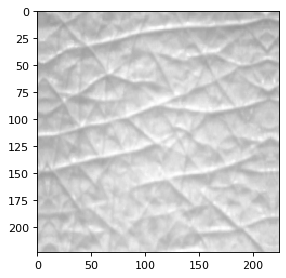

true label: [1 1 0 0]; rounded pred: [[0.5166481  0.22140986 0.38850772 0.5814764 ]]


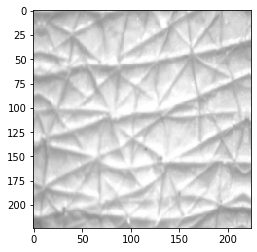

true label: [0 0 0 0]; rounded pred: [[0.5468512  0.22173548 0.23159054 0.77810663]]


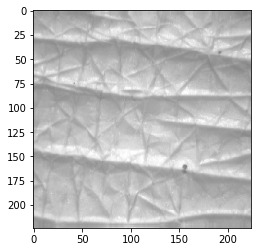

true label: [1 0 0 0]; rounded pred: [[0.32331324 0.12466377 0.27274    0.72847116]]


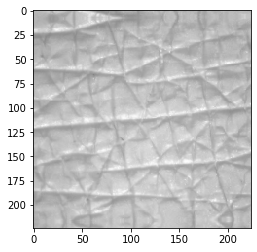

true label: [1 1 0 0]; rounded pred: [[0.46956223 0.13341662 0.4181247  0.48125947]]


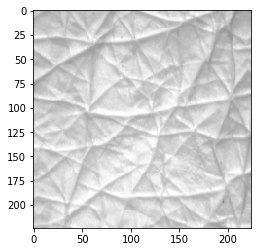

true label: [1 1 0 0]; rounded pred: [[0.5264354  0.18567577 0.3083903  0.6974536 ]]


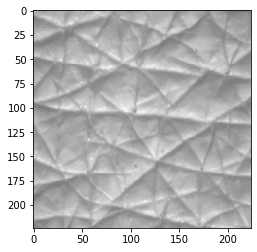

true label: [0 0 0 0]; rounded pred: [[0.49718612 0.15784404 0.30183932 0.68966484]]


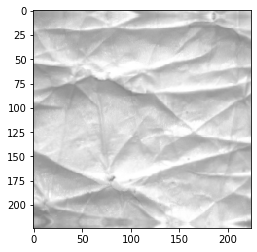

true label: [1 0 0 0]; rounded pred: [[0.40508974 0.16386059 0.29599285 0.6434768 ]]


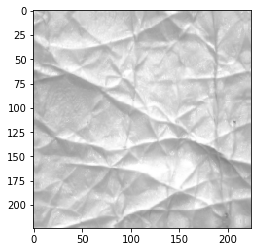

true label: [1 1 1 1]; rounded pred: [[0.5200292  0.1878765  0.3043211  0.51927626]]


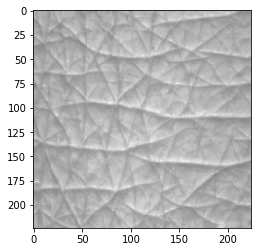

true label: [1 0 0 0]; rounded pred: [[0.46985728 0.15857068 0.290011   0.54323006]]


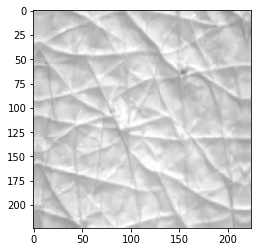

true label: [1 0 0 0]; rounded pred: [[0.5235144  0.14070183 0.33298078 0.7352144 ]]


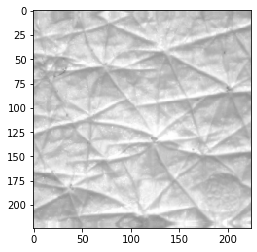

true label: [1 0 0 0]; rounded pred: [[0.52800614 0.16605899 0.3901257  0.6559229 ]]


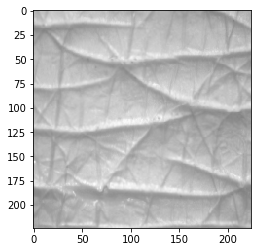

true label: [1 0 0 0]; rounded pred: [[0.48612294 0.17006212 0.29514542 0.70436585]]


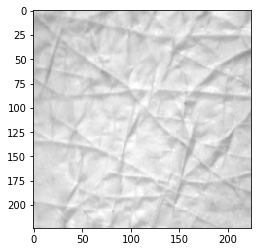

true label: [1 1 1 1]; rounded pred: [[0.5448687  0.19632065 0.40916947 0.5635129 ]]


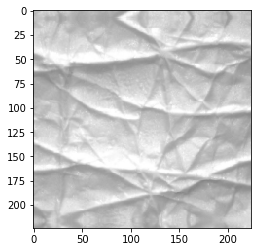

true label: [1 1 0 0]; rounded pred: [[0.43943778 0.17222914 0.25004137 0.6702702 ]]


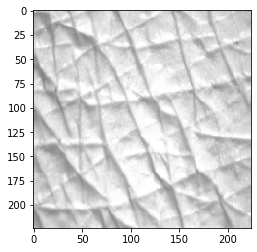

true label: [1 0 0 0]; rounded pred: [[0.5794725  0.11106482 0.3509627  0.6340244 ]]


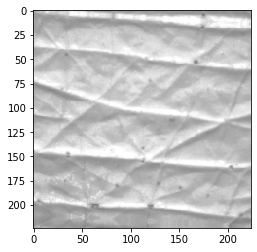

true label: [1 0 0 0]; rounded pred: [[0.5302152  0.1615189  0.31397146 0.7168753 ]]


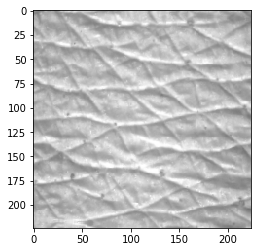

true label: [1 0 0 0]; rounded pred: [[0.53171366 0.2680192  0.3247454  0.590394  ]]


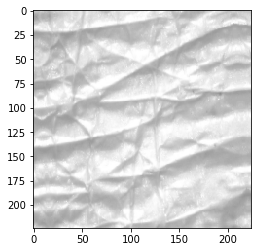

true label: [1 1 1 0]; rounded pred: [[0.512859   0.20187739 0.24238467 0.67815864]]


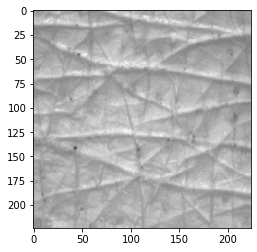

true label: [1 0 0 0]; rounded pred: [[0.4640188  0.11684823 0.40004778 0.63139886]]


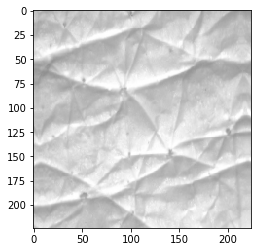

true label: [1 0 0 0]; rounded pred: [[0.54284793 0.22194654 0.3001424  0.676544  ]]


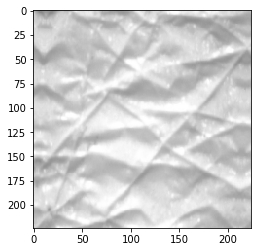

true label: [1 1 1 1]; rounded pred: [[0.49101987 0.25912008 0.27622896 0.5701218 ]]


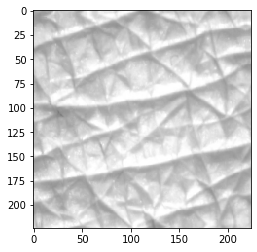

true label: [1 0 0 0]; rounded pred: [[0.4106958  0.15806183 0.3419118  0.69086653]]


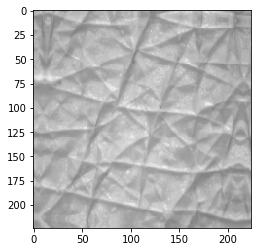

true label: [1 1 0 0]; rounded pred: [[0.4842462  0.14574498 0.37762842 0.6100297 ]]


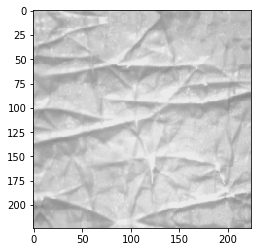

true label: [1 1 1 0]; rounded pred: [[0.45844114 0.25917023 0.3633539  0.58015585]]


In [20]:
fig, ax = plt.subplots(dpi=80)
batch = next(validation_set)

# print examples from the validation set
for i in range(len(batch[1])):
    img = batch[0][i]
    label = batch[1][i]
    plt.imshow(img)
    plt.show()
    print(f"true label: {label}; rounded pred: {model.predict(img.reshape(-1,224, 224, 3))}")